In [1]:
import sys
sys.path.append("..")

import torch
from ad import *
from fixer import *
from datasets import *
import matplotlib.pyplot as plt

/home/antonxue/lib/miniconda3/envs/arpro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cat = "bottle"

In [3]:
# ad_model = VaeADModel()
ad_model = FastflowAdModel()
# ad_save = torch.load("../_dump/ad_vae_mvtec_transistor_best.pt")
ad_save = torch.load(f"../_dump/ad_fast_mvtec_{cat}_best.pt")
ad_model.load_state_dict(ad_save["model_state_dict"])
ad_model.eval();

In [4]:
fixer_model = VaeFixerModel()
fixer_save = torch.load(f"../_dump/fixer_fast_mvtec_{cat}_best.pt")
fixer_model.load_state_dict(fixer_save["model_state_dict"])
fixer_model.eval();

In [5]:
torch.manual_seed(101)
N = 8
dataloader = get_fixer_dataloader("mvtec", "vae", batch_size=N, category=cat, split="test")
for batch in dataloader:
    break
x = 2*batch["image"] - 1
batch["label"]

tensor([0, 0, 1, 1, 0, 1, 0, 1])

In [6]:
with torch.no_grad():
    ad_out = ad_model(x)
    ad_score, ad_alpha = ad_out.score, ad_out.alpha

In [7]:
# x_recon = ad_out.others["x_recon"]
ad_alpha_max = ad_alpha.max(dim=1, keepdim=True).values

In [12]:
ad_thresh = ad_alpha_max.flatten(1).quantile(0.95,dim=1)
anom_parts = (ad_alpha_max > ad_thresh.view(N,1,1,1)).long()

<Figure size 640x480 with 0 Axes>

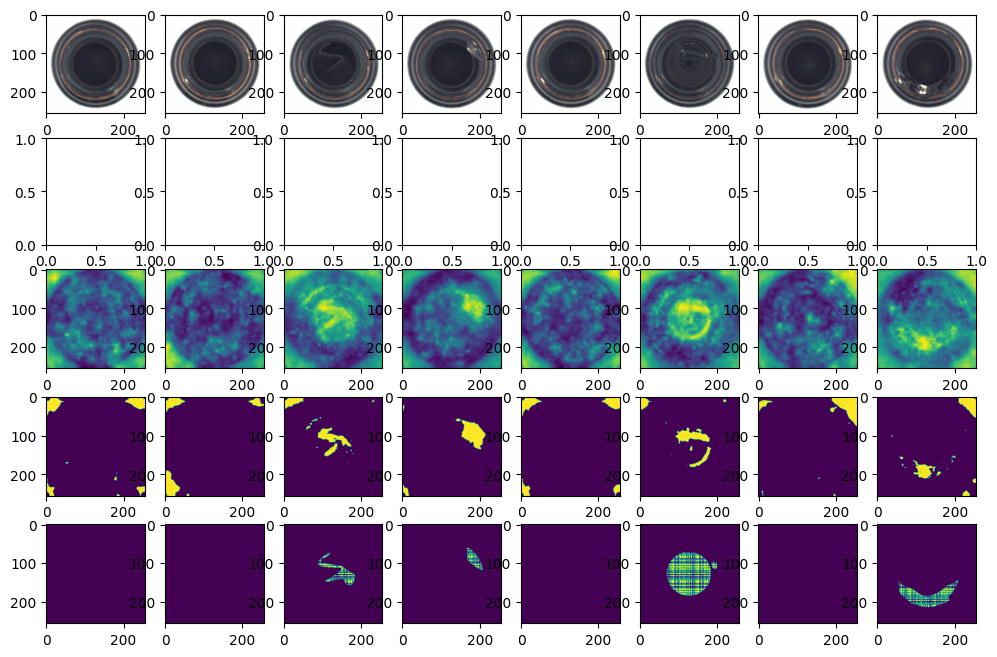

In [13]:
plt.clf()
fix, ax = plt.subplots(5,N,figsize=(12,8))

for i in range(N):
    xi = (x[i]*0.5 + 0.5).clamp(0,1)
    # xri = (x_recon[i]*0.5 + 0.5).clamp(0,1)
    ax[0,i].imshow(xi.numpy().transpose(1,2,0))
    # ax[1,i].imshow(xri.numpy().transpose(1,2,0))
    ax[2,i].imshow(ad_alpha_max[i].numpy().transpose(1,2,0))
    ax[3,i].imshow(anom_parts[i].numpy().transpose(1,2,0))
    ax[4,i].imshow(batch["mask"][i].numpy().transpose(1,2,0))

In [10]:
x_masked = x * (1 - anom_parts)
with torch.no_grad():
    fixer_out = fixer_model(x_masked, batch["mask"])
    # fixer_out = fixer_model(x_masked, anom_parts)
    x_fix = fixer_out.x_fix

<Figure size 640x480 with 0 Axes>

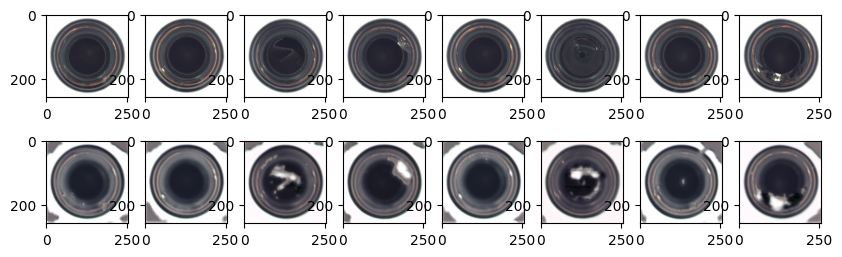

In [11]:
plt.clf()
fix, ax = plt.subplots(2, N, figsize=(10,3))

for i in range(N):
    xi = (x[i]*0.5 + 0.5).clamp(0,1)
    # xri = (x_recon[i]*0.5 + 0.5).clamp(0,1)
    xfi = (x_fix[i]*0.5 + 0.5).clamp(0,1)
    ax[0,i].imshow(xi.numpy().transpose(1,2,0))
    # ax[1,i].imshow(xri.numpy().transpose(1,2,0))
    ax[1,i].imshow(xfi.numpy().transpose(1,2,0))
    # ax[3,i].imshow((xi + 1e-1 * torch.randn(3,256,256)).clamp(0,1).numpy().transpose(1,2,0))